In [26]:
import tensorflow as tf
import cv2
import numpy as np
from matplotlib import pyplot as plt

In [27]:
data_dir = 'F:\MACHINE LEARNING\Train'

In [28]:
data = tf.keras.utils.image_dataset_from_directory(data_dir, image_size=(227, 227), batch_size=4)
print(data.class_names)
class_names = data.class_names

Found 300 files belonging to 3 classes.
['Mobil', 'Pesawat', 'Sepeda']


In [29]:
data_iterator = data.as_numpy_iterator()
print("data_iterator", data_iterator)

data_iterator <tensorflow.python.data.ops.dataset_ops._NumpyIterator object at 0x0000027E03289080>


In [30]:
batch = data_iterator.next()
print("batch", batch)

batch (array([[[[255.      , 255.      , 255.      ],
         [255.      , 255.      , 255.      ],
         [255.      , 255.      , 255.      ],
         ...,
         [255.      , 255.      , 255.      ],
         [255.      , 255.      , 255.      ],
         [255.      , 255.      , 255.      ]],

        [[255.      , 255.      , 255.      ],
         [255.      , 255.      , 255.      ],
         [255.      , 255.      , 255.      ],
         ...,
         [255.      , 255.      , 255.      ],
         [255.      , 255.      , 255.      ],
         [255.      , 255.      , 255.      ]],

        [[255.      , 255.      , 255.      ],
         [255.      , 255.      , 255.      ],
         [255.      , 255.      , 255.      ],
         ...,
         [255.      , 255.      , 255.      ],
         [255.      , 255.      , 255.      ],
         [255.      , 255.      , 255.      ]],

        ...,

        [[255.      , 255.      , 255.      ],
         [255.      , 255.      , 255.

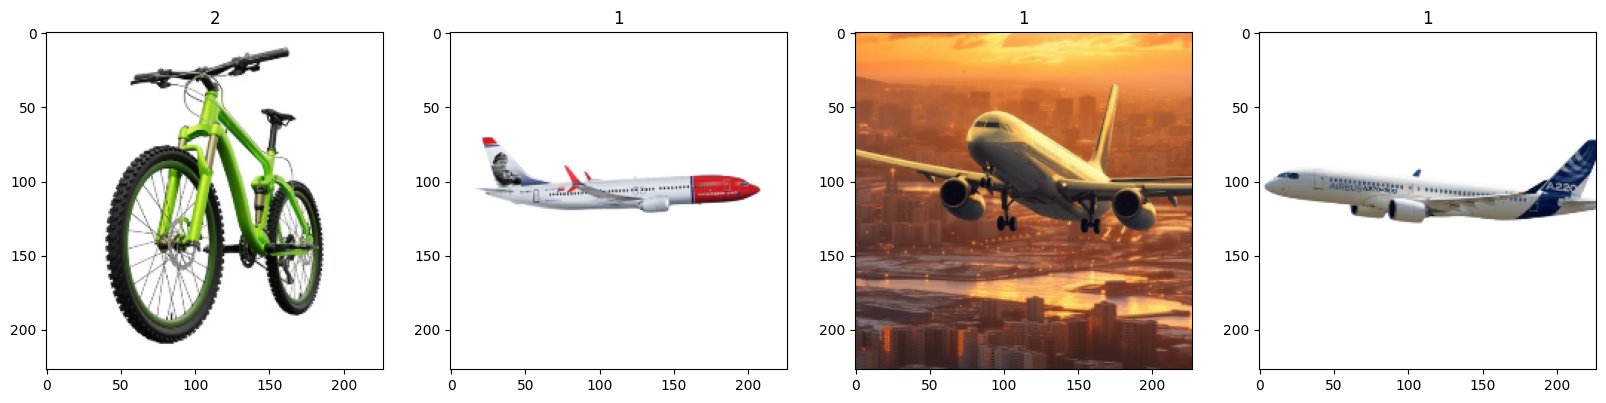

In [31]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

In [32]:
data = data.map(lambda x, y: (x / 255.0, y))
print("Tipe data setelah normalisasi: {}".format(data.element_spec))
print("Jumlah data", len(data))

Tipe data setelah normalisasi: (TensorSpec(shape=(None, 227, 227, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))
Jumlah data 75


In [33]:
total_batches = len(data)
train_size = int(total_batches * 0.8)
val_size = int(total_batches * 0.1)
test_size = int(total_batches * 0.1)

print(train_size)
print(val_size)
print(test_size)

train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size + val_size)

60
7
7


In [34]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Activation, Add, AveragePooling2D, Flatten, Dense
from tensorflow.keras.models import Model

def residual_block(x, filters, kernel_size=3, strides=1):
    
    y = Conv2D(filters, kernel_size=kernel_size, strides=strides, padding='same')(x)
    y = BatchNormalization()(y)
    y = Activation('relu')(y)

    y = Conv2D(filters, kernel_size=kernel_size, padding='same')(y)
    y = BatchNormalization()(y)

    # Koneksi Residual
    if strides > 1:
        x = Conv2D(filters, kernel_size=1, strides=strides, padding='same')(x)

    out = Add()([x, y])
    out = Activation('relu')(out)
    return out

def ResNet(input_shape, num_classes, depth=18):
    
    if (depth - 2) % 6 != 0:
        raise ValueError('Depth must be 6n + 2 (e.g., 20, 32, 44).')

    num_blocks = (depth - 2) // 6
    filters = 16

    inputs = Input(shape=input_shape)
    x = Conv2D(filters, kernel_size=3, padding='same')(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    
    for stack in range(3):
        for block in range(num_blocks):
            strides = 1
            if stack > 0 and block == 0:  
                strides = 2  # downsample

            x = residual_block(x, filters, strides=strides)

        filters *= 2

    x = AveragePooling2D(pool_size=8)(x)
    x = Flatten()(x)
    outputs = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=inputs, outputs=outputs, name='ResNet')
    return model


input_shape = (227, 227, 3)  
num_classes = 3
model = ResNet(input_shape, num_classes, depth=20)
model.summary()

Model: "ResNet"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 227, 227, 3)]        0         []                            
                                                                                                  
 conv2d_42 (Conv2D)          (None, 227, 227, 16)         448       ['input_3[0][0]']             
                                                                                                  
 batch_normalization_38 (Ba  (None, 227, 227, 16)         64        ['conv2d_42[0][0]']           
 tchNormalization)                                                                                
                                                                                                  
 activation_38 (Activation)  (None, 227, 227, 16)         0         ['batch_normalization_38[

In [35]:
model.compile(optimizer='adamax', loss='sparse_categorical_crossentropy', metrics=['accuracy'])


In [36]:
history = model.fit(train, epochs=20, validation_data = val)

Epoch 1/20
60/60 [==============================] - 90s 1s/step - loss: 0.7254 - accuracy: 0.7458 - val_loss: 1.2397 - val_accuracy: 0.5000
Epoch 2/20
60/60 [==============================] - 86s 1s/step - loss: 0.2533 - accuracy: 0.9083 - val_loss: 1.8058 - val_accuracy: 0.3929
Epoch 3/20
60/60 [==============================] - 85s 1s/step - loss: 0.1474 - accuracy: 0.9458 - val_loss: 2.3556 - val_accuracy: 0.4643
Epoch 4/20
60/60 [==============================] - 98s 2s/step - loss: 0.0974 - accuracy: 0.9583 - val_loss: 3.1401 - val_accuracy: 0.3571
Epoch 5/20
60/60 [==============================] - 103s 2s/step - loss: 0.0825 - accuracy: 0.9792 - val_loss: 2.3587 - val_accuracy: 0.3571
Epoch 6/20
60/60 [==============================] - 114s 2s/step - loss: 0.0493 - accuracy: 0.9917 - val_loss: 1.1771 - val_accuracy: 0.5000
Epoch 7/20
60/60 [==============================] - 106s 2s/step - loss: 0.0598 - accuracy: 0.9833 - val_loss: 0.5890 - val_accuracy: 0.7857
Epoch 8/20
60/60 

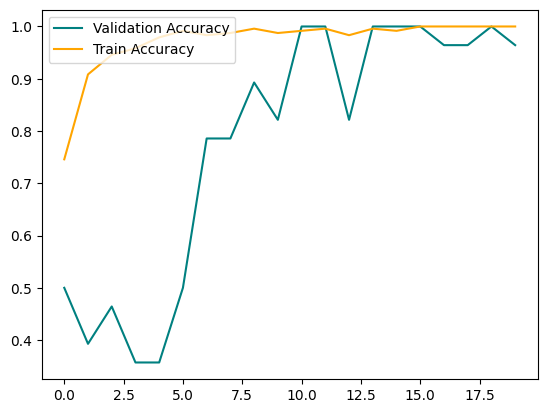

In [37]:
fig = plt.figure()
plt.plot(history.history['val_accuracy'], color='teal', label='Validation Accuracy')
plt.plot(history.history['accuracy'], color='orange', label='Train Accuracy')
plt.legend(loc="upper left")
plt.show()

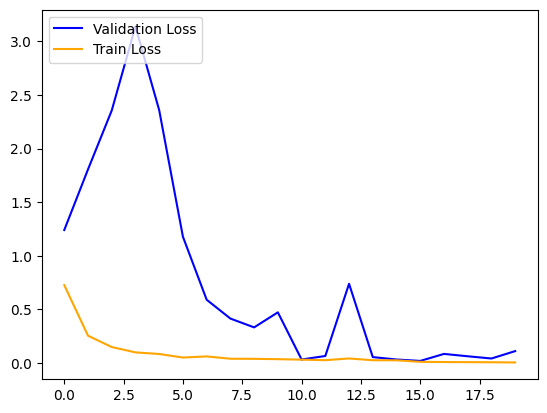

In [38]:
fig = plt.figure()
plt.plot(history.history['val_loss'], color='blue', label='Validation Loss')
plt.plot(history.history['loss'], color='orange', label='Train Loss')
plt.legend(loc="upper left")
plt.show()

In [39]:
model.evaluate(test)
model.save('F:\MACHINE LEARNING/ResNet_Kendaraan.h5')

8/8 [==============================] - 3s 310ms/step - loss: 0.2226 - accuracy: 0.9375


In [1]:
import tensorflow as tf
import cv2
import numpy as np
import matplotlib.pyplot as plt
model = tf.keras.models.load_model('F:\MACHINE LEARNING/ResNet_Kendaraan.h5')

(1, 227, 227, 3)


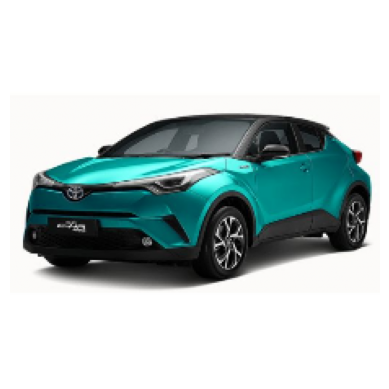

1/1 [==============================] - 0s 86ms/step
Kendaraan: Mobil
Confidence: 96.90274596214294
(1, 227, 227, 3)


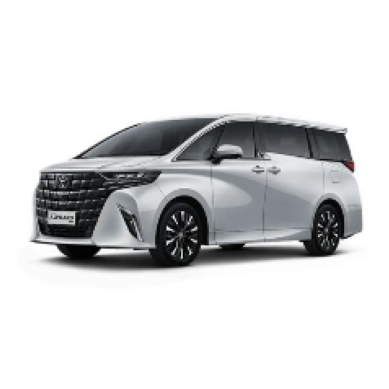

1/1 [==============================] - 0s 71ms/step
Kendaraan: Mobil
Confidence: 84.45074558258057
(1, 227, 227, 3)


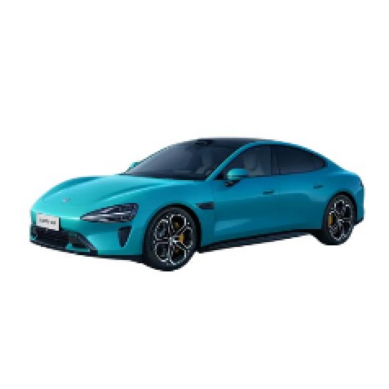

1/1 [==============================] - 0s 73ms/step
Kendaraan: Mobil
Confidence: 99.97896552085876
(1, 227, 227, 3)


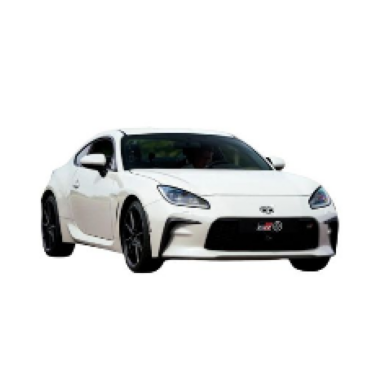

1/1 [==============================] - 0s 67ms/step
Kendaraan: Mobil
Confidence: 99.95492100715637
(1, 227, 227, 3)


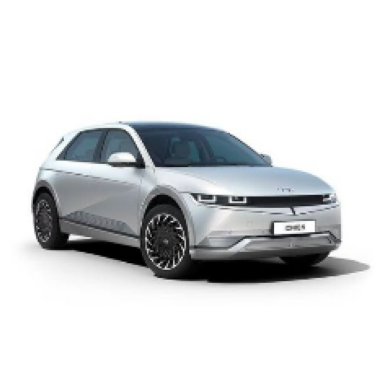

1/1 [==============================] - 0s 65ms/step
Kendaraan: Mobil
Confidence: 99.96553659439087
(1, 227, 227, 3)


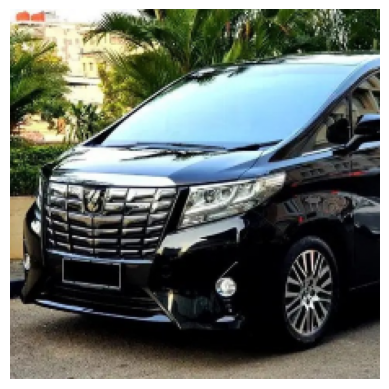

1/1 [==============================] - 0s 94ms/step
Kendaraan: Mobil
Confidence: 96.94749712944031
(1, 227, 227, 3)


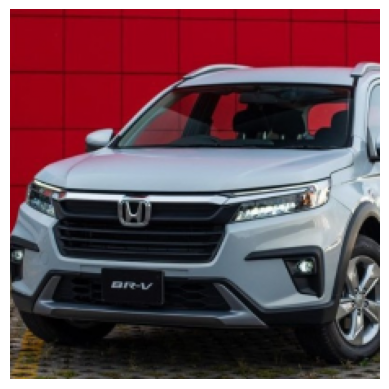

1/1 [==============================] - 0s 97ms/step
Kendaraan: Pesawat
Confidence: 99.69820380210876
(1, 227, 227, 3)


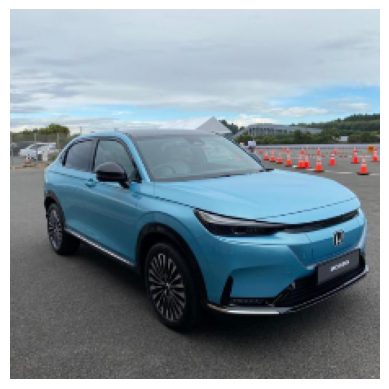

1/1 [==============================] - 0s 96ms/step
Kendaraan: Mobil
Confidence: 98.11619520187378
(1, 227, 227, 3)


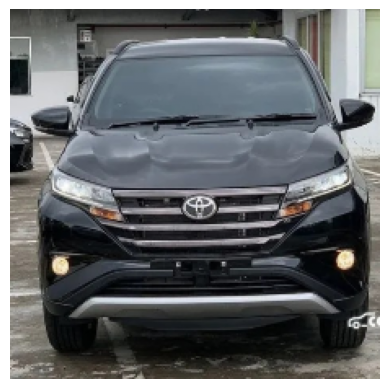

1/1 [==============================] - 0s 70ms/step
Kendaraan: Mobil
Confidence: 91.58312678337097
(1, 227, 227, 3)


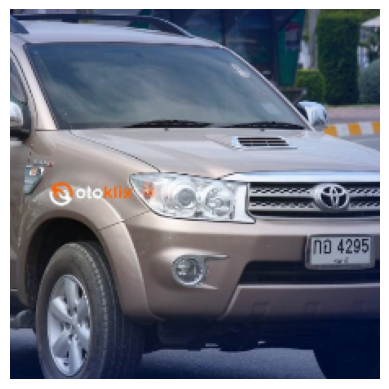

1/1 [==============================] - 0s 68ms/step
Kendaraan: Pesawat
Confidence: 95.36154270172119
(1, 227, 227, 3)


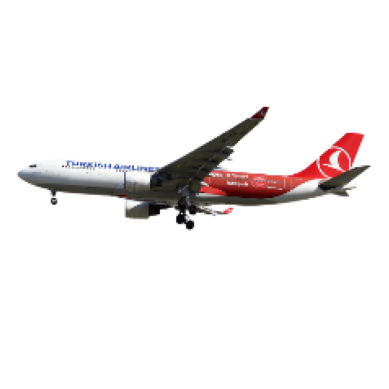

1/1 [==============================] - 0s 73ms/step
Kendaraan: Pesawat
Confidence: 99.97743964195251
(1, 227, 227, 3)


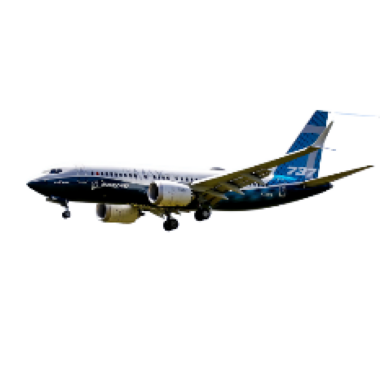

1/1 [==============================] - 0s 74ms/step
Kendaraan: Pesawat
Confidence: 99.93871450424194
(1, 227, 227, 3)


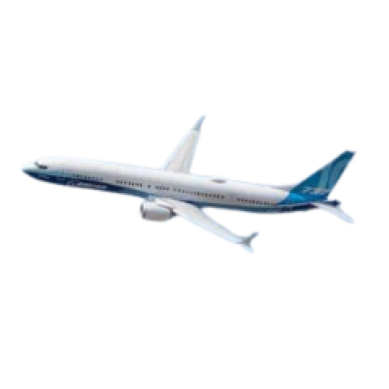

1/1 [==============================] - 0s 93ms/step
Kendaraan: Pesawat
Confidence: 99.92790818214417
(1, 227, 227, 3)


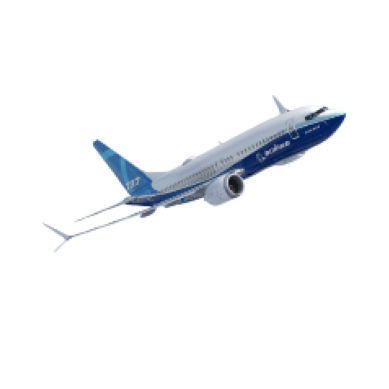

1/1 [==============================] - 0s 68ms/step
Kendaraan: Pesawat
Confidence: 82.05568790435791
(1, 227, 227, 3)


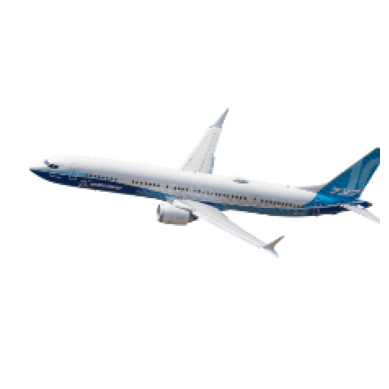

1/1 [==============================] - 0s 64ms/step
Kendaraan: Pesawat
Confidence: 99.98818635940552
(1, 227, 227, 3)


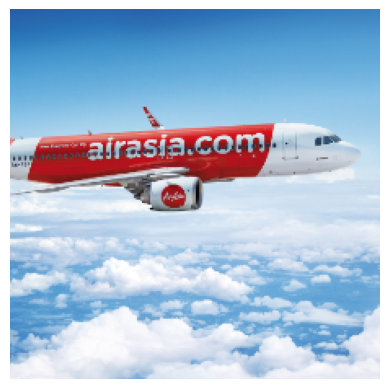

1/1 [==============================] - 0s 94ms/step
Kendaraan: Sepeda
Confidence: 98.44144582748413
(1, 227, 227, 3)


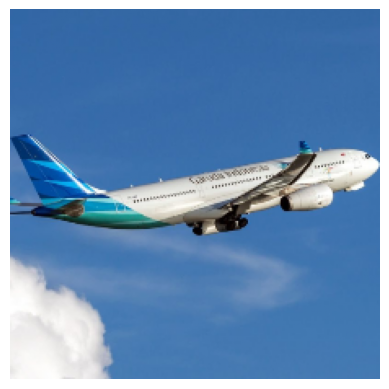

1/1 [==============================] - 0s 61ms/step
Kendaraan: Pesawat
Confidence: 99.97125267982483
(1, 227, 227, 3)


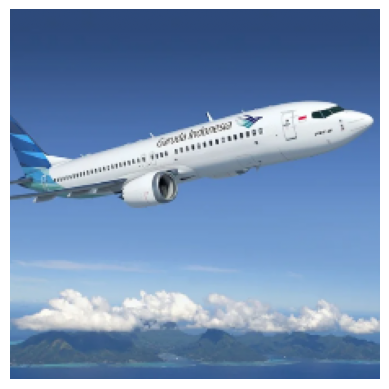

1/1 [==============================] - 0s 93ms/step
Kendaraan: Pesawat
Confidence: 99.40967559814453
(1, 227, 227, 3)


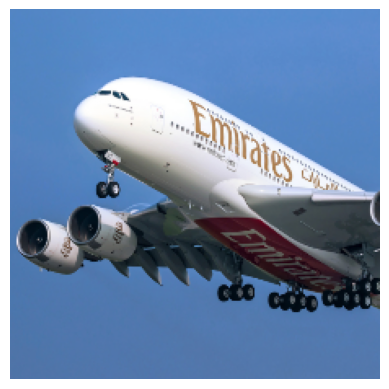

1/1 [==============================] - 0s 63ms/step
Kendaraan: Pesawat
Confidence: 99.78098273277283
(1, 227, 227, 3)


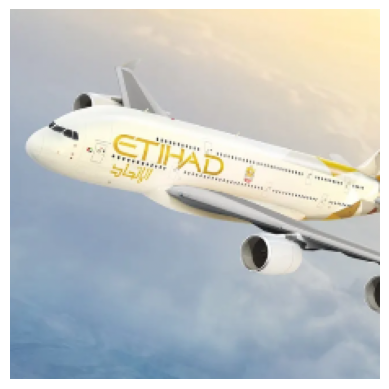

1/1 [==============================] - 0s 65ms/step
Kendaraan: Pesawat
Confidence: 62.61422038078308
(1, 227, 227, 3)


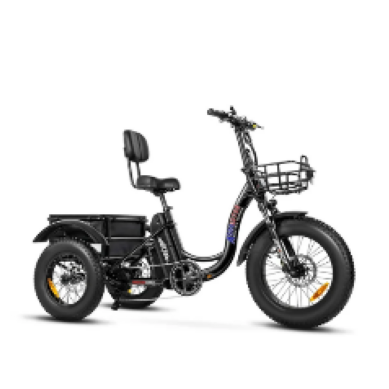

1/1 [==============================] - 0s 93ms/step
Kendaraan: Sepeda
Confidence: 96.33730053901672
(1, 227, 227, 3)


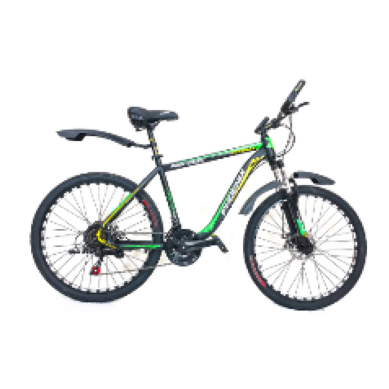

1/1 [==============================] - 0s 64ms/step
Kendaraan: Sepeda
Confidence: 99.99477863311768
(1, 227, 227, 3)


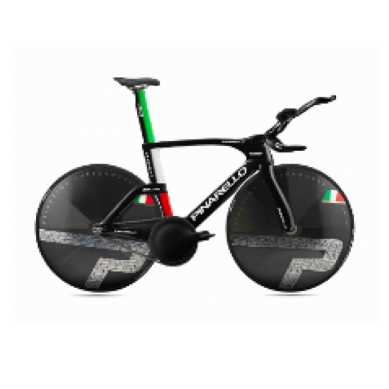

1/1 [==============================] - 0s 68ms/step
Kendaraan: Sepeda
Confidence: 98.94694089889526
(1, 227, 227, 3)


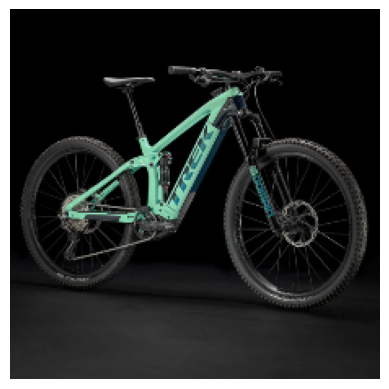

1/1 [==============================] - 0s 74ms/step
Kendaraan: Pesawat
Confidence: 71.97746634483337
(1, 227, 227, 3)


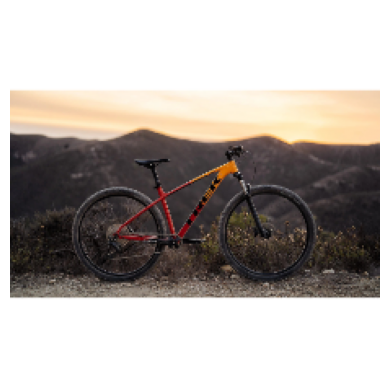

1/1 [==============================] - 0s 78ms/step
Kendaraan: Pesawat
Confidence: 75.57583451271057
(1, 227, 227, 3)


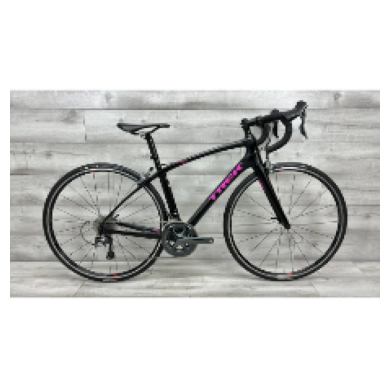

1/1 [==============================] - 0s 101ms/step
Kendaraan: Sepeda
Confidence: 99.9937891960144
(1, 227, 227, 3)


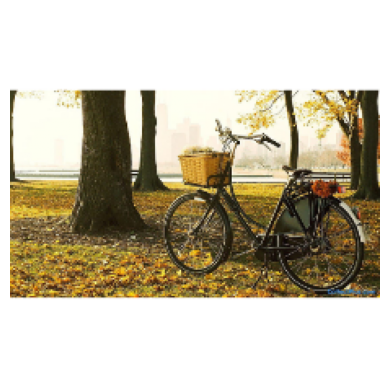

1/1 [==============================] - 0s 64ms/step
Kendaraan: Sepeda
Confidence: 99.57499504089355
(1, 227, 227, 3)


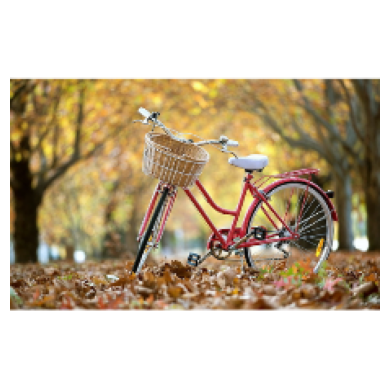

1/1 [==============================] - 0s 66ms/step
Kendaraan: Sepeda
Confidence: 99.89012479782104
(1, 227, 227, 3)


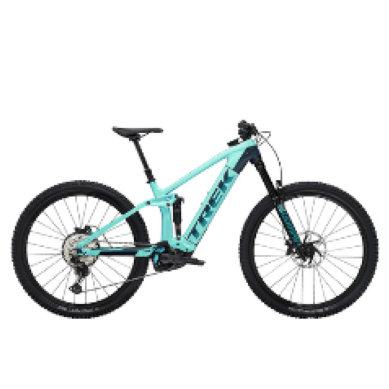

1/1 [==============================] - 0s 86ms/step
Kendaraan: Sepeda
Confidence: 99.99102354049683
(1, 227, 227, 3)


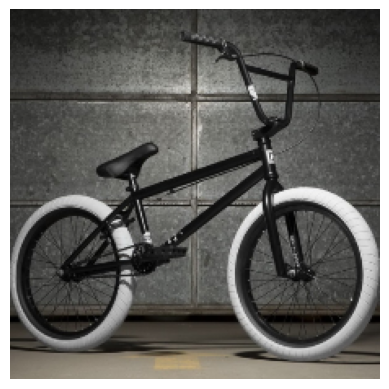

1/1 [==============================] - 0s 87ms/step
Kendaraan: Sepeda
Confidence: 64.13882374763489


In [4]:
import tensorflow as tf
import cv2
import numpy as np
import matplotlib.pyplot as plt

image_paths = [
    'F:\MACHINE LEARNING\Test\mobil101.jpg',
    'F:\MACHINE LEARNING\Test\mobil102.jpg',
    'F:\MACHINE LEARNING\Test\mobil103.jpg',
    'F:\MACHINE LEARNING\Test\mobil104.jpg',
    'F:\MACHINE LEARNING\Test\mobil105.jpg',
    'F:\MACHINE LEARNING\Test\mobil106.jpg',
    'F:\MACHINE LEARNING\Test\mobil107.jpg',
    'F:\MACHINE LEARNING\Test\mobil108.jpg',
    'F:\MACHINE LEARNING\Test\mobil109.jpg',
    'F:\MACHINE LEARNING\Test\mobil110.jpg',
    'F:\MACHINE LEARNING\Test\pesawat101.png',
    'F:\MACHINE LEARNING\Test\pesawat102.png',
    'F:\MACHINE LEARNING\Test\pesawat103.png',
    'F:\MACHINE LEARNING\Test\pesawat104.png',
    'F:\MACHINE LEARNING\Test\pesawat105.png',
    'F:\MACHINE LEARNING\Test\pesawat106.png',
    'F:\MACHINE LEARNING\Test\pesawat107.png',
    'F:\MACHINE LEARNING\Test\pesawat108.png',
    'F:\MACHINE LEARNING\Test\pesawat109.png',
    'F:\MACHINE LEARNING\Test\pesawat110.png',
    'F:\MACHINE LEARNING\Test\sepeda101.png',
    'F:\MACHINE LEARNING\Test\sepeda102.png',
    'F:\MACHINE LEARNING\Test\sepeda103.png',
    'F:\MACHINE LEARNING\Test\sepeda104.png',
    'F:\MACHINE LEARNING\Test\sepeda105.png',
    'F:\MACHINE LEARNING\Test\sepeda106.png',
    'F:\MACHINE LEARNING\Test\sepeda107.png',
    'F:\MACHINE LEARNING\Test\sepeda108.png',
    'F:\MACHINE LEARNING\Test\sepeda109.png',
    'F:\MACHINE LEARNING\Test\sepeda110.png'
]

class_names = ['Mobil', 'Pesawat', 'Sepeda']

for link in image_paths:
    img = cv2.imread(link)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_rgb_resized = cv2.resize(img_rgb, (227, 227))
    img_rgb_resized = img_rgb_resized / 255.0

    img_rgb_expanded = np.expand_dims(img_rgb_resized, axis=0)

    print(img_rgb_expanded.shape)

    plt.imshow(img_rgb_resized)
    plt.axis('off')
    plt.show()

    pred = model.predict(img_rgb_expanded)
    
    predicted_class_index = np.argmax(pred)
    confidence = pred[0][predicted_class_index] * 100
    
    print("Kendaraan:", class_names[predicted_class_index])
    print("Confidence:", confidence)